In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import random
import torch
import torchvision

from torchvision import datasets, transforms
import torchvision

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def configura():
    return None
configura.num_epochs = 50
configura.batch_size = 128
configura.learning_rate = 0.001
configura.train_valid = 0.8

In [4]:
label_mapping ={
    0: "T-shirt/Top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat", 
    5: "Sandal", 
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot"
    }

dftr = pd.read_csv("dat/fmnist_train.csv")
dfts = pd.read_csv("dat/fmnist_test.csv")

dftr = dftr.iloc[:-1,:-1]
dfts = dfts.iloc[:,:-1]

print(dftr.shape,dfts.shape)
dftr.head(3)


FileNotFoundError: [Errno 2] No such file or directory: 'dat/fmnist_train.csv'

In [5]:
if False:
    xtr = dftr.iloc[:int(configura.train_valid * len(dftr)), 1:].values
    xvl = dftr.iloc[int(configura.train_valid * len(dftr)):, 1:].values

    ytr = dftr.iloc[:int(configura.train_valid * len(dftr)), 0].values
    yvl = dftr.iloc[int(configura.train_valid * len(dftr)):, 0].values

    xts = dfts.values

    print(xtr.shape, xvl.shape, xts.shape, ytr.shape, yvl.shape)

    xtr = torch.tensor(xtr, dtype=torch.float32)
    xvl = torch.tensor(xvl, dtype=torch.float32)
    xts = torch.tensor(xts, dtype=torch.float32)

    ytr = torch.tensor(ytr, dtype=torch.int64)
    yvl = torch.tensor(yvl, dtype=torch.int64)

    train_ds = torch.utils.data.TensorDataset(xtr, ytr)
    valid_ds = torch.utils.data.TensorDataset(xvl, yvl)
    test_ds = torch.utils.data.TensorDataset(xts)

    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=configura.batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_ds, batch_size=configura.batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_ds, batch_size=configura.batch_size, shuffle=False)

if True:
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_dataset = datasets.FashionMNIST('data', train=True, download=True, transform=transform)
    test_dataset = datasets.FashionMNIST('data', train=True, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

if True:
    from torch.utils.data import ConcatDataset

    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    tr = datasets.FashionMNIST('data', train=True, download=True, transform=transform)
    ts = datasets.FashionMNIST('data', train=True, download=True, transform=transform)
    train_dataset = ConcatDataset([tr, ts])
    test_dataset = datasets.FashionMNIST('data', train=False, download=True, transform=transform)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


AttributeError: module 'torchvision.transforms' has no attribute 'Compose'

In [21]:
import torch.nn.functional as F

class ModelCNN(torch.nn.Module):
    def __init__(self):
        super(ModelCNN, self).__init__()

        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=256, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2)
        )

        self.fc1 = torch.nn.Linear(in_features=512*6*6, out_features=600)
        self.drop = torch.nn.Dropout(0.25)
        self.fc2 = torch.nn.Linear(in_features=600, out_features=120)
        self.fc3 = torch.nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = F.relu(out)  # Apply ReLU activation function
        out = self.drop(out)
        out = self.fc2(out)
        out = F.relu(out)  # Apply ReLU activation function
        out = self.fc3(out)

        return out

model = ModelCNN()
model.to(device)

error = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=configura.learning_rate)

print(model)

ModelCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=18432, out_features=600, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [23]:
import torch.nn.functional as F

class ModelCNN(torch.nn.Module):
    def __init__(self):
        super(ModelCNN, self).__init__()

        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=512, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3),
            torch.nn.BatchNorm2d(1024),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2)
        )

        self.fc1 = torch.nn.Linear(in_features=1024*6*6, out_features=600)
        self.drop = torch.nn.Dropout(0.25)
        self.fc2 = torch.nn.Linear(in_features=600, out_features=120)
        self.fc3 = torch.nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = F.relu(out)  # Apply ReLU activation function
        out = self.drop(out)
        out = self.fc2(out)
        out = F.relu(out)  # Apply ReLU activation function
        out = self.fc3(out)

        return out

model = ModelCNN()
model.to(device)

error = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=configura.learning_rate)

print(model)

ModelCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=36864, out_features=600, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [24]:
lossLst, iterLst, accuracyLst, predsLst, labelsLst = [], [], [], [], []
cnt = 0

for e in range(configura.num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        train = torch.autograd.Variable(images.view(-1,1,28,28))
        labels = torch.autograd.Variable(labels)

        outputs = model(train)
        loss = error(outputs, labels.long())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cnt += 1

        if cnt % 50 == 0:
            total, correct = 0, 0

            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                labelsLst.append(labels)

                valid = torch.autograd.Variable(images.view(-1,1,28,28))
                outputs = model(valid)

                preds = torch.max(outputs, 1)[1].to(device)
                predsLst.append(preds)

                total += len(labels)
                correct += (preds == labels).sum()

            accuracy = correct * 100 / total
            lossLst.append(loss.data)
            iterLst.append(cnt)
            accuracyLst.append(accuracy)

        if cnt % 500 == 0:
            print(f"Iteration: {cnt} Loss: {loss.data :.4f} Accuracy: {accuracy :.4f}")

Iteration: 500 Loss: 0.2857 Accuracy: 85.2406
Iteration: 1000 Loss: 0.2491 Accuracy: 86.8251
Iteration: 1500 Loss: 0.2885 Accuracy: 89.0258
Iteration: 2000 Loss: 0.3611 Accuracy: 89.5540
Iteration: 2500 Loss: 0.4196 Accuracy: 89.4366
Iteration: 3000 Loss: 0.3199 Accuracy: 90.4343
Iteration: 3500 Loss: 0.1905 Accuracy: 90.9331
Iteration: 4000 Loss: 0.1162 Accuracy: 91.6373
Iteration: 4500 Loss: 0.1309 Accuracy: 92.0188
Iteration: 5000 Loss: 0.1348 Accuracy: 92.5176
Iteration: 5500 Loss: 0.0906 Accuracy: 92.9871
Iteration: 6000 Loss: 0.1134 Accuracy: 92.3709
Iteration: 6500 Loss: 0.1470 Accuracy: 94.2782
Iteration: 7000 Loss: 0.2555 Accuracy: 94.5716
Iteration: 7500 Loss: 0.0847 Accuracy: 93.0164
Iteration: 8000 Loss: 0.1675 Accuracy: 94.7477
Iteration: 8500 Loss: 0.1820 Accuracy: 94.3075
Iteration: 9000 Loss: 0.0935 Accuracy: 94.1315
Iteration: 9500 Loss: 0.1243 Accuracy: 95.5106
Iteration: 10000 Loss: 0.0844 Accuracy: 94.0434
Iteration: 10500 Loss: 0.0522 Accuracy: 95.4812
Iteration: 1

KeyboardInterrupt: 

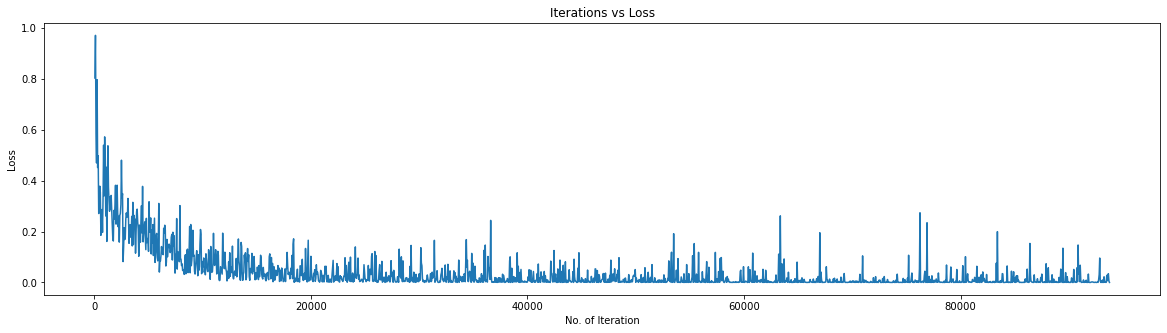

In [14]:
plt.figure(figsize=(20,5))
plt.plot(iterLst, lossLst)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

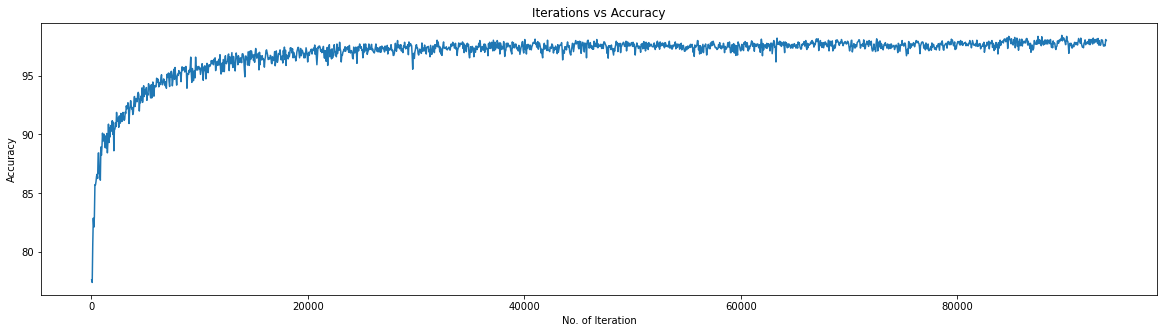

In [164]:
plt.figure(figsize=(20,5))
plt.plot(iterLst, accuracyLst)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

In [165]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)
        test = torch.autograd.Variable(images.view(-1,1,28,28))
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(len(images)):
            label = labels[i]
            class_correct[label.int()] += c[i].item()
            total_correct[label.int()] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(label_mapping[i], class_correct[i] * 100 / total_correct[i]))

Accuracy of T-shirt/Top: 98.40%
Accuracy of Trouser: 99.70%
Accuracy of Pullover: 97.33%
Accuracy of Dress: 96.79%
Accuracy of Coat: 96.24%
Accuracy of Sandal: 99.41%
Accuracy of Shirt: 93.17%
Accuracy of Sneaker: 99.11%
Accuracy of Bag: 100.00%
Accuracy of Ankle Boot: 99.35%


In [3]:
xtr = dftr.iloc[:int(configura.train_valid * len(dftr)), 1:].values
xvl = dftr.iloc[int(configura.train_valid * len(dftr)):, 1:].values

ytr = dftr.iloc[:int(configura.train_valid * len(dftr)), 0].values
yvl = dftr.iloc[int(configura.train_valid * len(dftr)):, 0].values

xts = dfts.values

print(xtr.shape, xvl.shape, xts.shape, ytr.shape, yvl.shape)

xtr = torch.tensor(xtr, dtype=torch.float32)
xvl = torch.tensor(xvl, dtype=torch.float32)
xts = torch.tensor(xts, dtype=torch.float32)

ytr = torch.tensor(ytr, dtype=torch.int64)
yvl = torch.tensor(yvl, dtype=torch.int64)

train_ds = torch.utils.data.TensorDataset(xtr, ytr)
valid_ds = torch.utils.data.TensorDataset(xvl, yvl)
test_ds = torch.utils.data.TensorDataset(xts)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=configura.batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_ds, batch_size=configura.batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=configura.batch_size, shuffle=False)

NameError: name 'dftr' is not defined

In [167]:
result = []
for images in test_loader:
    images = images[0].to(device)
    test = torch.autograd.Variable(images.view(-1,1,28,28))
    outputs = model(test)
    predicted = torch.max(outputs, 1)[1]
    result.append(predicted)

In [168]:
submission = pd.read_csv("dat/sample_submission.csv")
submission.Category = [int(x) for sl in result for x in sl]
print(submission.shape)
submission.head(3)

(10000, 2)


,Id,Category
0,0,0
1,1,1
2,2,2


In [169]:
submission.to_csv("result/submission.csv", index=False)
pd.read_csv("result/submission.csv")

,Id,Category
0,0,0
1,1,1
2,2,2
3,3,2
4,4,3
...,...,...
9995,9995,0
9996,9996,6
9997,9997,8
9998,9998,8


In [25]:
!ls result

submission.csv


In [22]:
!rm result/submission.csv

In [496]:
!mv /home/jovyan/kaggle.json /home/jovyan/.kaggle/

In [170]:
!kaggle competitions submit -c mds-mipt-dl-test-final -f result/submission.csv -m "gleb kabanov"

100%|██████████████████████████████████████| 67.3k/67.3k [00:01<00:00, 42.6kB/s]
Successfully submitted to [MDS-MIPT-DL-TEST] Классификация изображений